In [1]:
import pandas as pd
from lifelines import CoxPHFitter
from lifelines.utils import concordance_index

In [2]:
df1 = pd.read_csv('g:\\BLCA1.csv')
df2 = pd.read_csv('g:\\BLCA2.csv')

In [3]:
df1['SurvivalTime'] = df1['days_to_death'] / 30.44
df2['SurvivalTime'] = df2['days_to_death'] / 30.44

selected_genes = ['CD74', 'PSMB1', 'HSP90B1', 'HSPA5', 'CCT7','RALA','MDH1','NFE2L2','ATP5MC1','PCMT1','ZFAND5']
gene_columns = ['event', 'SurvivalTime'] + selected_genes

df1 = df1[gene_columns]
df2 = df2[gene_columns]

In [4]:
print("df1 列名:", df1.columns)
print("df2 列名:", df2.columns)

df1 列名: Index(['event', 'SurvivalTime', 'CD74', 'PSMB1', 'HSP90B1', 'HSPA5', 'CCT7',
       'RALA', 'MDH1', 'NFE2L2', 'ATP5MC1', 'PCMT1', 'ZFAND5'],
      dtype='object')
df2 列名: Index(['event', 'SurvivalTime', 'CD74', 'PSMB1', 'HSP90B1', 'HSPA5', 'CCT7',
       'RALA', 'MDH1', 'NFE2L2', 'ATP5MC1', 'PCMT1', 'ZFAND5'],
      dtype='object')


In [5]:
print("df2 'event' 列样本值:", df2['event'].head())

df2 'event' 列样本值: 0    1
1    1
2    1
3    1
4    1
Name: event, dtype: int64


In [6]:
matched_pairs = []

for i, row1 in df1.iterrows():
    for j, row2 in df2.iterrows():
        if row1['event'] == 1 and row2['event'] == 1 and row1['SurvivalTime'] < row2['SurvivalTime']:
            matched_pairs.append((i, j))

In [7]:
cph = CoxPHFitter()

In [8]:
cph.fit(df1, duration_col='SurvivalTime', event_col='event')
cph = CoxPHFitter(penalizer=0.01)
cph.fit(df2, duration_col='SurvivalTime', event_col='event')

<lifelines.CoxPHFitter: fitted with 96 total observations, 5 right-censored observations>

In [9]:
predicted_survival_1 = cph.predict_survival_function(df1)
predicted_hazard_1 = -cph.predict_partial_hazard(df1)
predicted_survival_1_values = predicted_survival_1.values


predicted_survival_2 = cph.predict_survival_function(df2)
predicted_hazard_2 = -cph.predict_partial_hazard(df2)
predicted_survival_2_values = predicted_survival_2.values

In [10]:
print("event_times shape:", df1['SurvivalTime'].shape)
print("predicted_scores shape:", predicted_survival_1.shape)

print("event_times shape:", df2['SurvivalTime'].shape)
print("predicted_scores shape:", predicted_survival_2.shape)

event_times shape: (95,)
predicted_scores shape: (83, 95)
event_times shape: (96,)
predicted_scores shape: (83, 96)


In [11]:
df = pd.concat([df1, df2], ignore_index=True)

In [12]:
cph = CoxPHFitter()
cph.fit(df, duration_col='SurvivalTime', event_col='event')

<lifelines.CoxPHFitter: fitted with 191 total observations, 5 right-censored observations>

In [13]:
predicted_hazard = -cph.predict_partial_hazard(df)

In [14]:
c_index = concordance_index(event_times=df['SurvivalTime'], predicted_scores=predicted_hazard, event_observed=df['event'])
print(f"C-index for the entire dataset: {c_index}")

C-index for the entire dataset: 0.6703144862654065


In [15]:
import matplotlib.pyplot as plt

predicted_survival = cph.predict_survival_function(df)

In [16]:
import matplotlib.pyplot as plt

In [17]:
predicted_survival_1 = cph.predict_survival_function(df1)
predicted_survival_2 = cph.predict_survival_function(df2)

In [18]:
import matplotlib.pyplot as plt

predicted_survival_1 = cph.predict_survival_function(df1[['CD74', 'PSMB1', 'HSP90B1', 'HSPA5', 'CCT7','RALA','MDH1','NFE2L2','ATP5MC1','PCMT1','ZFAND5']])
predicted_survival_2 = cph.predict_survival_function(df2[['CD74', 'PSMB1', 'HSP90B1', 'HSPA5', 'CCT7','RALA','MDH1','NFE2L2','ATP5MC1','PCMT1','ZFAND5']])

mean_survival_1 = predicted_survival_1.mean(axis=1)
mean_survival_2 = predicted_survival_2.mean(axis=1)

In [19]:
import matplotlib.pyplot as plt
from lifelines.statistics import logrank_test

results = logrank_test(df1['SurvivalTime'], df2['SurvivalTime'], event_observed_A=df1['event'], event_observed_B=df2['event'])
p_value = results.p_value

In [20]:
import matplotlib.pyplot as plt
from lifelines.statistics import logrank_test

results = logrank_test(df1['SurvivalTime'], df2['SurvivalTime'], event_observed_A=df1['event'], event_observed_B=df2['event'])
p_value = results.p_value

In [21]:
import matplotlib.pyplot as plt
predicted_survival_1 = cph.predict_survival_function(df1[ ['CD74', 'PSMB1', 'HSP90B1', 'HSPA5', 'CCT7','RALA','MDH1','NFE2L2','ATP5MC1','PCMT1','ZFAND5']])
predicted_survival_2 = cph.predict_survival_function(df2[ ['CD74', 'PSMB1', 'HSP90B1', 'HSPA5', 'CCT7','RALA','MDH1','NFE2L2','ATP5MC1','PCMT1','ZFAND5']])

mean_survival_1 = predicted_survival_1.mean(axis=1)
mean_survival_2 = predicted_survival_2.mean(axis=1)

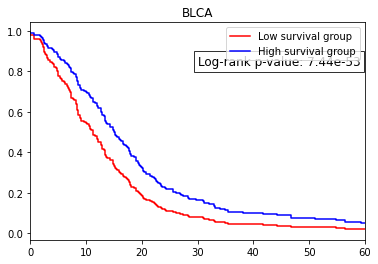

In [22]:
min_time = min(mean_survival_1.index.min(), mean_survival_2.index.min())
max_time = max(mean_survival_1.index.max(), mean_survival_2.index.max())
plt.xlim(0, 60)
plt.step(mean_survival_1.index, mean_survival_1.values, label='Low survival group', color='red')
plt.step(mean_survival_2.index, mean_survival_2.values, label='High survival group', color='blue')
plt.title('BLCA')
plt.text(30, 0.83, f'Log-rank p-value: {p_value:.2e}', fontsize=12, color='black', bbox=dict(facecolor='white', alpha=0.8))
plt.legend()
plt.show()
